# 新闻视频处理演示

在这个笔记本中，我们将要针对一则来自江西湖口的本地新闻进行如下的处理：

1. 按照 `cut-scene` 来切割出若干镜头

1. 对上一步切割出来的镜头进行分类，识别出:

  - 演播室（没有字幕）
  - 演播室（带有字幕）
  - 其它

1. 识别带有字幕的演播室镜头中的字幕文本

1. 识别演播室镜头中，播音员播报的语音内容，将它转为文本

## 环境准备

我们已经准备好了一个 Conda 环境 `jxcn-newsvideo`，注意选择这个笔记本的 Kernel 为上诉环境！

- 如果还没有配置 Conda 环境，执行下面的 cell ，保证依赖包被正确安装到该笔记本是使用 Kernel
- 如果已经配置好了 Conda 环境，不必重复执行

这个步骤完成后，如果有新安装的软件，应重启 Kernel，然后下次运行笔记本的时候，跳过安装过程

In [1]:
%conda env update --file ../environment.yml

Solving environment: done

chardet-3.0.4        | 197 KB    | ##################################### | 100% 
certifi-2019.6.16    | 156 KB    | ##################################### | 100% 
cftime-1.0.3.4       | 318 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Ran pip subprocess with arguments:
['/home/liuxy/miniconda3/envs/jxcn-newsvideo/bin/python', '-m', 'pip', 'install', '-U', '-r', '/home/liuxy/workspace/jxcn-newvideo-poc/condaenv.a_6dm20g.requirements.txt']
Pip subprocess output:
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Requirement already up-to-date: scenedetect>=0.5 in /home/liuxy/miniconda3/envs/jxcn-newsvideo/lib/python3.6/site-packages (from -r /home/liuxy/workspace/jxcn-newvideo-poc/condaenv.a_6dm20g.requirements.txt (line 1)) (0.5.1)

#
# To activate this environment, use
#
#     $ conda activate jxcn-newsvideo
#
# To deactivate an active environment, use
#
#     

准备完毕之后，我们还需要：

1. 验证 PyTorch 的情况

1. 设置 matplotlib 中文字体

   请根据实际情况设置有效的字体！

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
import torch

mfm_font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
mfm_font_prop = mfm.FontProperties(fname=mfm_font_path)
plt.text(.5, .5, s='中文绘图显示测试', fontproperties=mfm_font_prop)
plt.show()

plt.pause(1)

print('PyTouch version: ', torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

<Figure size 640x480 with 1 Axes>

PyTouch version:  1.0.1
cuda


## 上传要处理的视频文件

上传一个湖口的新闻视频，并指定其路径。

本例中，我们上传文件 *湖口* *2019年05月16日* 的新闻录像到:

```sh
../videos/湖口/20190516.mp4
```

> **提示：**
>
> 笔记本 Web 界面左侧的文件浏览器支持拖拽

将文件路径复制到全局变量。后面的步骤需要使用该变量进行计算：

In [2]:
import os

VIDEO_DIR = '../videos'

# 定义要处理的视频文件路径之全局变量
VIDEO_FILE = os.path.join(
    VIDEO_DIR,
    "../videos/湖口/20190516.mp4"  # 在这里填写新实际要进行处理的视频文件！
)

print('要处理的文件：', os.path.abspath(VIDEO_FILE))  # 输出文件绝对路径
assert os.path.exists(VIDEO_FILE)  # 断言：文件存在

要处理的文件： /home/liuxy/workspace/jxcn-newvideo-poc/videos/湖口/20190516.mp4


在下面的步骤中，我们将针对这个视频文件进行处理。

## 根据视觉表征进行场景边界预测

我们之前已经准备了一个使用根据图像表征进行视频场景边界检测的预训练模型。

这个模型可以预测出视频场景边界。

我们使用这个模型，对上传的新闻视频文件进行一次处理，得到它的场景边界，并生成场景的缩略图。

In [3]:
from contextlib import contextmanager

from scenedetect.video_manager import VideoManager
from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import SceneManager
from scenedetect.stats_manager import StatsManager

@contextmanager
def managed_video_manager(*args, **kwargs):
    video_manager = VideoManager(*args, **kwargs)
    try:
        yield video_manager
    finally:
        video_manager.release()

def cut_scenes(video_file_path):
    # cut-scenes 检测
    stats_manager = StatsManager()
    scene_manager = SceneManager(stats_manager)
    scene_manager.add_detector(ContentDetector())
    
    with managed_video_manager([str(video_file_path)]) as video_manager:
        # detect scenes
        video_manager.start()
        base_time_code = video_manager.get_base_timecode()
        num_frames = scene_manager.detect_scenes(frame_source=video_manager)
        if not num_frames > 0:
            raise RuntimeError('No scenes detected')
        scene_list = scene_manager.get_scene_list(base_time_code)
    # Ok.
    # 拼凑结果数据
    scenes = []
    for index, (start_time_code, end_time_code) in enumerate(scene_list):
        scenes.append({
            'index': index,
            'start_time': start_time_code.get_seconds(),
            'end_time': end_time_code.get_seconds(),
            'start_frame': start_time_code.get_frames(),
            'end_frame': end_time_code.get_frames(),
        })
    return scenes

scenes = cut_scenes(VIDEO_FILE)

100%|██████████| 18477/18477 [03:47<00:00, 81.39frames/s]


检测到的场景列表是（包含：顺序编号、起止时间、起止帧）：

In [4]:
import pandas as pd

pd.DataFrame(scenes)

end_frame  end_time  index  start_frame  start_time
0          125      5.00      0            0        0.00
1          231      9.24      1          125        5.00
2          411     16.44      2          231        9.24
3          437     17.48      3          411       16.44
4          474     18.96      4          437       17.48
5          923     36.92      5          474       18.96
6          951     38.04      6          923       36.92
7          982     39.28      7          951       38.04
8         1004     40.16      8          982       39.28
9         1024     40.96      9         1004       40.16
10        1047     41.88     10         1024       40.96
11        1068     42.72     11         1047       41.88
12        1101     44.04     12         1068       42.72
13        1139     45.56     13         1101       44.04
14        1173     46.92     14         1139       45.56
15        1207     48.28     15         1173       46.92
16        1250     50.00     16         1207       48.28
17        1376     55.04     17         1250       50.00
18        2521    100.84     18         1376       55.04
19        2615    104.60     19         2521      100.84
20        3149    125.96     20         2615      104.60
21        3262    130.48     21         3149      125.96
22        3375    135.00     22         3262      130.48
23        3488    139.52     23         3375      135.00
24        3601    144.04     24         3488      139.52
25        3714    148.56     25         3601      144.04
26        3814    152.56     26         3714      148.56
27        3914    156.56     27         3814      152.56
28        4014    160.56     28         3914      156.56
29        4107    164.28     29         4014      160.56
..         ...       ...    ...          ...         ...
110      15114    604.56    110        14998      599.92
111      15277    611.08    111        15114      604.56
112      15363    614.52    112        15277      611.08
113      15428    617.12    113        15363      614.52
114      15536    621.44    114        15428      617.12
115      15595    623.80    115        15536      621.44
116      15694    627.76    116        15595      623.80
117      15784    631.36    117        15694      627.76
118      15867    634.68    118        15784      631.36
119      15930    637.20    119        15867      634.68
120      15995    639.80    120        15930      637.20
121      16083    643.32    121        15995      639.80
122      16188    647.52    122        16083      643.32
123      16268    650.72    123        16188      647.52
124      16337    653.48    124        16268      650.72
125      16402    656.08    125        16337      653.48
126      16476    659.04    126        16402      656.08
127      16562    662.48    127        16476      659.04
128      16927    677.08    128        16562      662.48
129      17030    681.20    129        16927      677.08
130      17117    684.68    130        17030      681.20
131      17290    691.60    131        17117      684.68
132      17376    695.04    132        17290      691.60
133      17449    697.96    133        17376      695.04
134      17523    700.92    134        17449      697.96
135      17593    703.72    135        17523      700.92
136      17693    707.72    136        17593      703.72
137      17795    711.80    137        17693      707.72
138      17879    715.16    138        17795      711.80
139      18477    739.08    139        17879      715.16

[140 rows x 5 columns]

## 缩略图预览

根据检测到的场景，从原始视频文件生成每个场景的缩略图:

../tmp/images/湖口/20190516


100%|██████████| 140/140 [00:14<00:00,  9.55it/s]


make ImageGrid figure...
make sub-plot ...


0it [00:00, ?it/s]/home/liuxy/miniconda3/envs/jxcn-newsvideo/lib/python3.6/site-packages/matplotlib/offsetbox.py:1250: UserWarning: Mixing horizontalalignment or verticalalignment with AnchoredText is not supported.
  warnings.warn("Mixing horizontalalignment or verticalalignment "
140it [00:04, 32.38it/s]


plotting ...


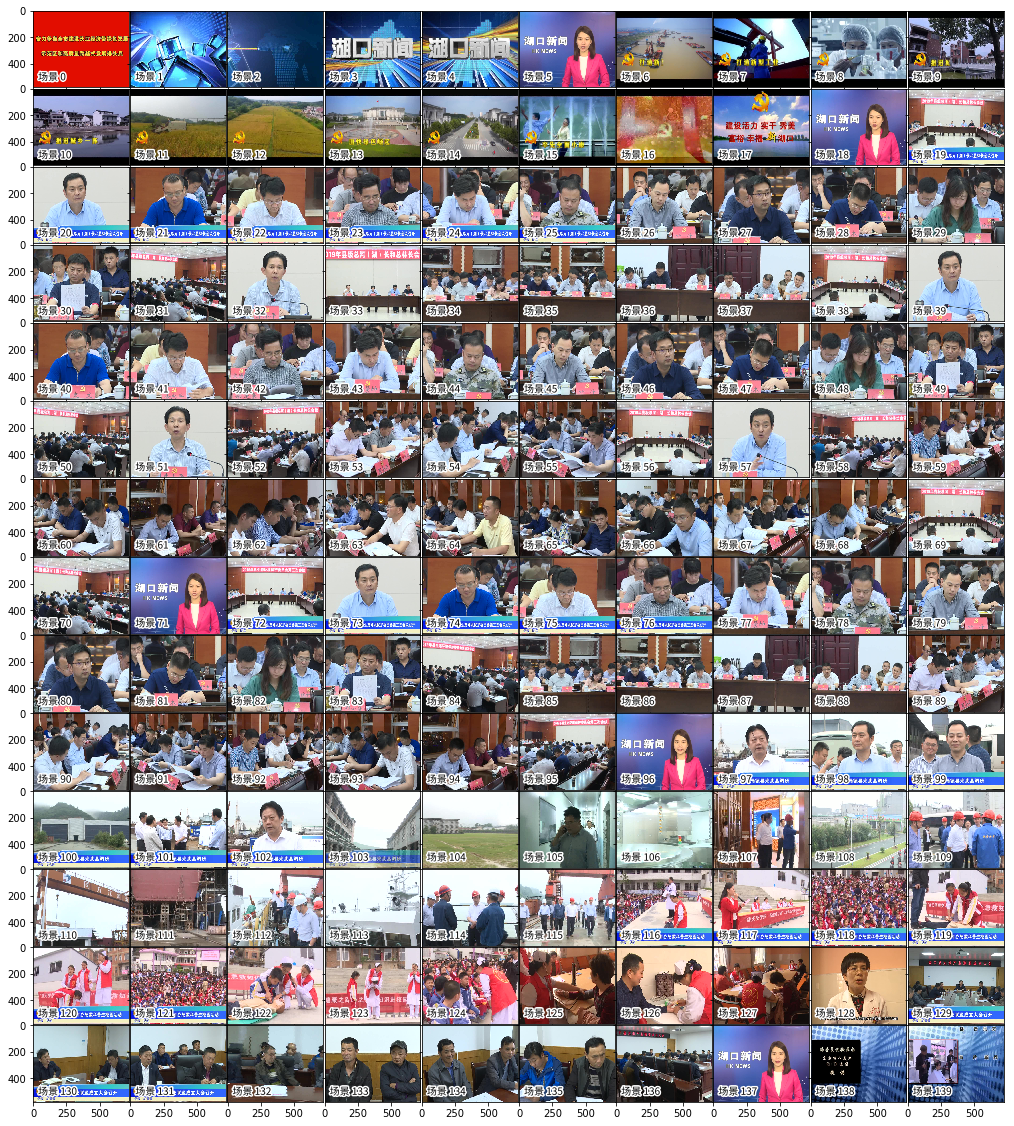

CPU times: user 22 µs, sys: 3 µs, total: 25 µs
Wall time: 30.3 µs


In [5]:
import os
import os
import subprocess
from time import sleep
from shutil import rmtree
from datetime import timedelta
from string import Template

from tqdm import tqdm_notebook as tqdm


def run_ffmpeg(args=None, quiet=True, check=True, cmd=None):
    if not cmd:
        cmd = 'ffmpeg'
    args = args or []
    if quiet:
        kv_args = dict(stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    else:
        kv_args = dict()
    subprocess.run([cmd, '-y'] + args, check=check, **kv_args)

    
def take_images_in_timespan(
        video_file_path,
        start_time,
        end_time,
        output_file_name_format='$index.jpg',
        num=3
):
    output_tpl = Template(output_file_name_format)
    time_points = []
    img_file_list = []
    if num == 1:
        time_points.append(
            start_time + (end_time - start_time) / 2
        )
    else:
        span = (end_time - start_time) / (num - 1)
        time_points.append(start_time)
        for i in range(num - 2):
            time_points.append(
                start_time + span * (i + 1)
            )
        time_points.append(end_time)
    #
    for i, ss in enumerate(time_points):
        ss = timedelta(seconds=ss)
        output_path = output_tpl.substitute(index=i + 1)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        run_ffmpeg([
            '-ss', str(ss), '-i', video_file_path, '-vframes', '1', output_path
        ])
        img_file_list.append(output_path)
    return img_file_list


def take_scenes_images(video_file_path, scenes, output_dir):
    # 输出目录
    os.makedirs(output_dir, exist_ok=True)
    # 生成缩略图文件
    for i, scene in tqdm(enumerate(scenes), total=len(scenes)):
        start_time = scene['start_time']
        end_time = scene['end_time']
        snapshots = take_images_in_timespan(
            video_file_path, start_time, end_time,
            os.path.join(output_dir, '{}_$index.jpg'.format(i + 1)),
            1
        )
        scene['snapshots'] = snapshots

        
dirname, basename = os.path.split(VIDEO_FILE)
basename = os.path.splitext(basename)[0]
images_dir = os.path.join(
    '..',
    'tmp',
    'images',
    os.path.relpath(dirname, VIDEO_DIR),
    basename
)
rmtree(images_dir, ignore_errors=True)

print(images_dir)
sleep(1)

take_scenes_images(VIDEO_FILE, scenes, images_dir)

sleep(1)

# 我们可以通过这些缩略图观察场景检测的结果

from time import sleep

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image


def add_inner_title(ax, title, loc, size=None, **kwargs):
    prop = kwargs.get('prop', {})
    if size is None:
        prop['size'] = plt.rcParams['legend.fontsize']
    at = AnchoredText(title, loc=loc, pad=0., borderpad=0.5, frameon=False, **kwargs)
    # at = AnchoredText(title, loc=loc, prop={'fontproperties': mfm_font_prop}, pad=0., borderpad=0.5, frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at


n_cols= 10
n_rows = int(np.ceil(len(scenes) / n_cols))
im_dsp_w = 80
im_dsp_h = 60

print('make ImageGrid figure...')
sleep(1)

fig = plt.figure(figsize=(im_dsp_w, im_dsp_h))
grid = ImageGrid(
    fig, len(scenes),  # similar to subplot(142)
    nrows_ncols=(n_rows, n_cols),
)

print('make sub-plot ...')
sleep(1)

text_prop={'fontproperties': mfm_font_prop}
for ax, scene in tqdm(zip(grid, scenes)):
    t = add_inner_title(ax, f'场景 {scene["index"]}', loc=3, prop=text_prop)
    t.patch.set_alpha(0.5)
    im = mpimg.imread(scene['snapshots'][0])
    ax.imshow(im, interpolation="nearest")


print('plotting ...')

plt.pause(0.001)
%time plt.show()


## 对场景进行视觉分类

我们已经制作了一个小的，可进行场景图像分类的预训练模型，它可以将场景分为：

* `0`: 无字幕内容
* `1`: 有字幕内容
* `2`: 演播室

现在，执行场景视觉分类，并输出缩略图预

预测: 场景分类 ...
CPU times: user 32 s, sys: 1.97 s, total: 33.9 s
Wall time: 5.58 s
预测完毕!
make ImageGrid figure...
make sub-plot ...


0it [00:00, ?it/s]/home/liuxy/miniconda3/envs/jxcn-newsvideo/lib/python3.6/site-packages/matplotlib/offsetbox.py:1250: UserWarning: Mixing horizontalalignment or verticalalignment with AnchoredText is not supported.
  warnings.warn("Mixing horizontalalignment or verticalalignment "
140it [00:04, 31.90it/s]


plotting ...


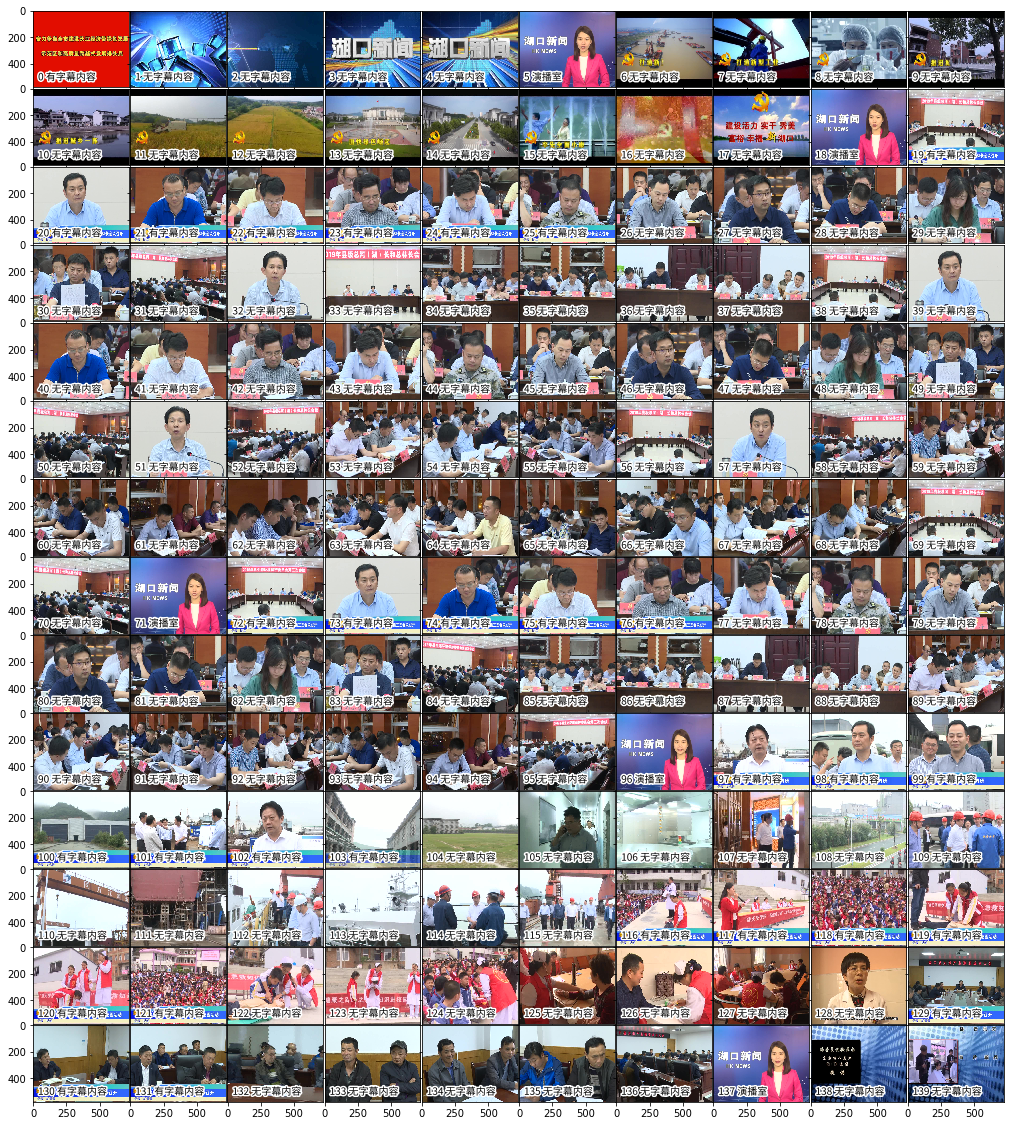

In [6]:
# 首先，定义相关的变量、函数，导入需要的模块，加载预训练模型：

import torch
from torchvision import datasets, models, transforms


IMAGE_CLASSES = {
    0: '无字幕内容',
    1: '有字幕内容',
    2: '演播室',
}


INPUT_SIZE = 224


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
}


def load_image_classify_model(path):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if device.type == 'cpu':
        model_ft = torch.load(path, map_location='cpu')
        if isinstance(model_ft, nn.DataParallel):
            model_ft = model_ft.module
    else:
        if torch.cuda.device_count() > 1:
            model_ft = torch.load(path)
            model_ft = model_ft.to(device)
    return model_ft



def classify_scenes(scenes, model):
    tsfrm = data_transforms['val']
    samples_iter = (
        tsfrm(transforms.ToPILImage()(skimage.io.imread(path)))
        for path in (
            scene['snapshots'][0]
            for scene in scenes
        )
    )
    with torch.no_grad():
        model = model.eval()
        batched_samples = torch.tensor([np.array(im) for im in samples_iter]).to(device)
        predict_result = model(batched_samples)
    
    for scores, scene in zip(predict_result, scenes):
        class_score = sorted(chain.from_iterable(zip(enumerate(scores))), key=lambda x: x[1], reverse=True)
        top_class, top_score = class_score[0]
        scene['class'] = top_class
        scene['class_name'] = IMAGE_CLASSES[top_class]

image_classify_model_archive = '../models/squeezenet1_0-py36.pkl'
image_classify_model = load_image_classify_model(image_classify_model_archive)

# print('加载的预训练模型是:', image_classify_model)
# 执行场景视觉分类，并输出缩略图预览

from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from torchvision import datasets, models, transforms
from time import sleep

from matplotlib.offsetbox import AnchoredText
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image

from tqdm import tqdm_notebook as tqdm


def add_inner_title(ax, title, loc, size=None, **kwargs):
    prop = kwargs.get('prop', {})
    if size is None:
        prop['size'] = plt.rcParams['legend.fontsize']
    at = AnchoredText(title, loc=loc, pad=0., borderpad=0.5, frameon=False, **kwargs)
    # at = AnchoredText(title, loc=loc, prop={'fontproperties': mfm_font_prop}, pad=0., borderpad=0.5, frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at


print('预测: 场景分类 ...')
%time classify_scenes(scenes, image_classify_model)
print('预测完毕!')

n_cols= 10
n_rows = int(np.ceil(len(scenes) / n_cols))
im_dsp_w = 80
im_dsp_h = 60

print('make ImageGrid figure...')
sleep(1)

fig = plt.figure(figsize=(im_dsp_w, im_dsp_h))
grid = ImageGrid(
    fig, len(scenes),  # similar to subplot(142)
    nrows_ncols=(n_rows, n_cols),
)

print('make sub-plot ...')
sleep(1)

text_prop={'fontproperties': mfm_font_prop}
for ax, scene in tqdm(zip(grid, scenes)):
    t = add_inner_title(ax, f'{scene["index"]} {scene["class_name"]}', loc=3, prop=text_prop)
    t.patch.set_alpha(0.5)
    im = mpimg.imread(scene['snapshots'][0])
    ax.imshow(im, interpolation="nearest")

print('plotting ...')

plt.pause(0.001)
plt.show()


## 字幕转文本

使用 *场景识别分类* 一节中，被预测到具有字幕的内容，将图像中的字幕识别为文本

In [11]:
# 被预测为被为“有字幕内容” 的场景：

print('被预测为被为“有字幕内容” 的场景：\n')

import pandas as pd

pd.DataFrame(
    scene
    for scene in scenes
    if scene['class'] == 1
).sort_values(by='index')

被预测为被为“有字幕内容” 的场景：



class class_name  end_frame  end_time  index  \
0       1      有字幕内容        125      5.00      0   
1       1      有字幕内容       2615    104.60     19   
2       1      有字幕内容       3149    125.96     20   
3       1      有字幕内容       3262    130.48     21   
4       1      有字幕内容       3375    135.00     22   
5       1      有字幕内容       3488    139.52     23   
6       1      有字幕内容       3601    144.04     24   
7       1      有字幕内容       3714    148.56     25   
8       1      有字幕内容      10049    401.96     72   
9       1      有字幕内容      10583    423.32     73   
10      1      有字幕内容      10696    427.84     74   
11      1      有字幕内容      10809    432.36     75   
12      1      有字幕内容      10922    436.88     76   
13      1      有字幕内容      13610    544.40     97   
14      1      有字幕内容      13816    552.64     98   
15      1      有字幕内容      13908    556.32     99   
16      1      有字幕内容      14015    560.60    100   
17      1      有字幕内容      14134    565.36    101   
18      1      有字幕内容      14270    570.80    102   
19      1      有字幕内容      14406    576.24    103   
20      1      有字幕内容      15694    627.76    116   
21      1      有字幕内容      15784    631.36    117   
22      1      有字幕内容      15867    634.68    118   
23      1      有字幕内容      15930    637.20    119   
24      1      有字幕内容      15995    639.80    120   
25      1      有字幕内容      16083    643.32    121   
26      1      有字幕内容      17030    681.20    129   
27      1      有字幕内容      17117    684.68    130   
28      1      有字幕内容      17290    691.60    131   

                                snapshots  start_frame  start_time  
0     [../tmp/images/湖口/20190516/1_1.jpg]            0        0.00  
1    [../tmp/images/湖口/20190516/20_1.jpg]         2521      100.84  
2    [../tmp/images/湖口/20190516/21_1.jpg]         2615      104.60  
3    [../tmp/images/湖口/20190516/22_1.jpg]         3149      125.96  
4    [../tmp/images/湖口/20190516/23_1.jpg]         3262      130.48  
5    [../tmp/images/湖口/20190516/24_1.jpg]         3375      135.00  
6    [../tmp/images/湖口/20190516/25_1.jpg]         3488      139.52  
7    [../tmp/images/湖口/20190516/26_1.jpg]         3601      144.04  
8    [../tmp/images/湖口/20190516/73_1.jpg]         9961      398.44  
9    [../tmp/images/湖口/20190516/74_1.jpg]        10049      401.96  
10   [../tmp/images/湖口/20190516/75_1.jpg]        10583      423.32  
11   [../tmp/images/湖口/20190516/76_1.jpg]        10696      427.84  
12   [../tmp/images/湖口/20190516/77_1.jpg]        10809      432.36  
13   [../tmp/images/湖口/20190516/98_1.jpg]        13417      536.68  
14   [../tmp/images/湖口/20190516/99_1.jpg]        13610      544.40  
15  [../tmp/images/湖口/20190516/100_1.jpg]        13816      552.64  
16  [../tmp/images/湖口/20190516/101_1.jpg]        13908      556.32  
17  [../tmp/images/湖口/20190516/102_1.jpg]        14015      560.60  
18  [../tmp/images/湖口/20190516/103_1.jpg]        14134      565.36  
19  [../tmp/images/湖口/20190516/104_1.jpg]        14270      570.80  
20  [../tmp/images/湖口/20190516/117_1.jpg]        15595      623.80  
21  [../tmp/images/湖口/20190516/118_1.jpg]        15694      627.76  
22  [../tmp/images/湖口/20190516/119_1.jpg]        15784      631.36  
23  [../tmp/images/湖口/20190516/120_1.jpg]        15867      634.68  
24  [../tmp/images/湖口/20190516/121_1.jpg]        15930      637.20  
25  [../tmp/images/湖口/20190516/122_1.jpg]        15995      639.80  
26  [../tmp/images/湖口/20190516/130_1.jpg]        16927      677.08  
27  [../tmp/images/湖口/20190516/131_1.jpg]        17030      681.20  
28  [../tmp/images/湖口/20190516/132_1.jpg]        17117      684.68

## 语音转本文

使用 *场景识别分类* 一节中，被预测到是演播室的内容，将播报的语音识别为文本

In [7]:
import os
from shutil import rmtree

import pandas as pd
from tqdm import tqdm as tqdm


def trunc_av(video_file_path, start_seconds, end_seconds, output_path):
    start_time = timedelta(seconds=start_seconds)
    duration = timedelta(seconds=(end_seconds - start_seconds))
    args = [
        '-ss', str(start_time),
        '-i', str(video_file_path),
        '-t', str(duration),
        '-c', 'copy',
        # output:
        str(output_path)
    ]
    run_ffmpeg(args=args, quiet=False)

def trunc_a(video_file_path, start_seconds, end_seconds, output_path):
    output_file, _ = os.path.splitext(output_path)
    output_path = output_file + '.mp3'
    start_time = timedelta(seconds=start_seconds)
    duration = timedelta(seconds=(end_seconds - start_seconds))
    args = [
        '-ss', str(start_time),
        '-i', str(video_file_path),
        '-t', str(duration),
        '-vn', '-acodec', 'libmp3lame', '-b:a', '16k',
        # output:
        str(output_path)
    ]
    run_ffmpeg(args=args)
    

print('提取演播室音视频 ...')

merged_speech_scenes = []

curr_matched_scene = dict()
for i in range(len(scenes)):
    is_first = i == 0
    is_last = not(i < len(scenes))
    if scenes[i]['class'] == 2:  # 这个是演播室
        if curr_matched_scene:
            if is_last:
                curr_matched_scene['end_time'] = scenes[i]['end_time']
        else:
            if is_last:
                curr_matched_scene['start_time'] = scenes[i]['start_time']
                curr_matched_scene['end_time'] = scenes[i]['end_time']
            else:
                curr_matched_scene['start_time'] = scenes[i]['start_time']
    else:  # 这个不是演播室
        if curr_matched_scene:
            curr_matched_scene['end_time'] = scenes[i-1]['end_time']
            merged_speech_scenes.append(curr_matched_scene)
            curr_matched_scene = dict()

#
dirname, basename = os.path.split(VIDEO_FILE)
basename, extname = os.path.splitext(basename)
clips_dir = os.path.join(
    '..',
    'tmp',
    'clips',
    os.path.relpath(dirname, VIDEO_DIR),
    basename
)
rmtree(clips_dir, ignore_errors=True)

sleep(1)

for i, scene in tqdm(enumerate(merged_speech_scenes)):
    scene['video_file'] = os.path.join(clips_dir, f'speech_{i}{extname}')
    os.makedirs(os.path.dirname(scene['video_file']), exist_ok=True)
    
    scene['audio_file'] = os.path.join(clips_dir, f'speech_{i}.mp3')
    os.makedirs(os.path.dirname(scene['audio_file']), exist_ok=True)
    
    trunc_av(VIDEO_FILE, scene['start_time'], scene['end_time'], scene['video_file'])
    trunc_a(VIDEO_FILE, scene['start_time'], scene['end_time'], scene['audio_file'])

# pd.DataFrame(merged_speech_scenes)

print('语音识别 ...')
sleep(1)

import json

import weblfasr_python3_demo as lfasr
from tqdm import tqdm_notebook as tqdm

for scene in tqdm(merged_speech_scenes):
    asr_req = lfasr.RequestApi("5afcedf6", "15681c0387b69e806546dd56defa6dbd", scene['audio_file'])
    res = asr_req.all_api_request()
    asr_res_data = json.loads(res['data'])
    scene['text'] = ''.join(m['onebest'] for m in asr_res_data)


提取演播室音视频 ...


5it [00:04,  1.36it/s]


语音识别 ...


/prepare success:{'data': '55370766b6854624b8a3d39aaf8e7768', 'err_no': 0, 'failed': None, 'ok': 0}
/upload success:{'data': None, 'err_no': 0, 'failed': None, 'ok': 0}
upload slice 1 success
/merge success:{'data': None, 'err_no': 0, 'failed': None, 'ok': 0}
/getProgress success:{'data': '{"status":2,"desc":"音频合并完成"}', 'err_no': 0, 'failed': None, 'ok': 0}
The task 55370766b6854624b8a3d39aaf8e7768 is in processing, task status: {"status":2,"desc":"音频合并完成"}
/getProgress success:{'data': '{"status":9,"desc":"转写结果上传完成"}', 'err_no': 0, 'failed': None, 'ok': 0}
task 55370766b6854624b8a3d39aaf8e7768 finished
/getResult success:{'data': '[{"bg":"580","ed":"1880","onebest":"观众朋友晚上好！","speaker":"0"},{"bg":"1880","ed":"4330","onebest":"今天是2019年5月16号星期四，","speaker":"0"},{"bg":"4780","ed":"5000","onebest":"今天。","speaker":"0"},{"bg":"5010","ed":"7030","onebest":"湖口新闻的主要内容有","speaker":"0"},{"bg":"7050","ed":"8020","onebest":"2019年。","speaker":"0"},{"bg":"8030","ed":"8730","onebest":"县级总和！","speaker

下面，我们在笔记本中循环打印出显示演播室的视频片段，对比识别出来的语音转文本结果，看看效果：

In [8]:
from IPython.display import display, Audio, Video

for scene in merged_speech_scenes:
    display(Video(scene['video_file']))
    print(scene['text'])
    print()

观众朋友晚上好！今天是2019年5月16号星期四，今天。湖口新闻的主要内容有2019年。县级总和！胡长和总领长会议召开。2019年。全县生态环境。保护委员会第三次会议召开，下面请看详细报道！



5月15号。县委书记李小平主持召开2019年县级总和。胡长。和总磷长会议，他强调要从树牢四个意识进行两个。维护的政治高度！切实把河。长制壶长，治林长治各项工作任务落到实处！努力保护好我县河湖森林资源，不断巩固提升绿色生态优势，为争当全市建设长江经济带绿色发展示范区和。高质量！两跨越式发展排头兵提供有力保障。县委副书记县长相信开出席会议并讲话，县委副书记张楠，县政协主席杨小林见领导，使文章中品张鹏来，柯景坤马海燕叶子卢伟俊李水木杨庆周小喜出席会议。



5月15号。县委书记李小平主持召开2019年全县生态环境。保护委员会第。三次会议，县委副书记县长相信开出席会议并讲话，县委副书记张楠，县政协主席杨小林，谢领导使文章中评张红来，柯景坤，马海燕叶子路伟俊李水木杨庆周小喜出席会议，会议听取了。各专业委员会个专项整改小组工作进展情况和问题整改情况的汇报。



5月15号，市工信局党委书记局长陈南桥来我县就传统产业转型升级和沿江小化工企业初侵等工作进行调研。县委副书记。县长相信，开县领导柯景坤叶子陪同！



好，以上就是今天新闻的全部内容，感谢收看，再见！

